# Neural machine translation

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/

In [2]:
#!wget http://www.manythings.org/anki/rus-eng.zip

In [3]:
#!mkdir rus-eng
#!unzip rus-eng.zip -d rus-eng/

In [4]:
#!ls /content/rus-eng/ -lah

In [5]:
# Download the file
path_to_file = "./content/rus-eng/rus.txt"

In [6]:
def preprocess_sentence(w):
    w = w.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [7]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [8]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [9]:
en, ru = create_dataset(path_to_file, None)
print(en[-1])
print(ru[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с уч том миллионов живущих на земле людей , ни один подходящи

In [10]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [11]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)


In [12]:
len(en), len(ru)

(429117, 429117)

In [13]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [14]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [15]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
6 ----> том
218 ----> слышал
3427 ----> крик
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> tom
205 ----> heard
9 ----> a
1429 ----> shout
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [17]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

# Transformer

<img src="images/transformer.png"/>


Идея в том, что каждое слово параллельно проходит через слои, изображенные на картинке.
Некоторые из них — это стандартные fully-connected layers, некоторые — shortcut connections как в ResNet (там, где на картинке Add).


Multi-head attention - это специальный новый слой, который дает возможность каждому входному вектору взаимодействовать с другими словами через attention mechanism, вместо передачи hidden state как в RNN или соседних слов как в CNN.


<img src="images/mha.png"/>


<img src="images/AttTr.png"/>


Работа энкодера:


Делаются эмбеддинги для всех слов предложения (вектора одинаковой размерности). Для примера пусть это будет предложение I am stupid. В эмбеддинг добавляется еще позиция слова в предложении.


Берется вектор первого слова и вектор второго слова (I, am), подаются на однослойную сеть с одним выходом, которая выдает степень их похожести (скалярная величина). Эта скалярная величина умножается на вектор второго слова, получая его некоторую "ослабленную" на величину похожести копию.


Вместо второго слова подается третье слово и делается тоже самое что в п.2. с той же самой сетью с теми же весами (для векторов I, stupid).


Делая тоже самое для всех оставшихся слов предложения получаются их "ослабленные" (взвешенные) копии, которые выражают степень их похожести на первое слово. Далее эти все взвешенные вектора складываются друг с другом, получая один результирующий вектор размерности одного эмбединга:
output=am * weight(I, am) + stupid * weight(I, stupid)


Это механизм "обычного" attention.
Так как оценка похожести слов всего одним способом (по одному критерию) считается недостаточной, тоже самое (п.2-4) повторяется несколько раз с другими весами. Типа одна один attention может определять похожесть слов по смысловой нагрузке, другой по грамматической, остальные еще как-то и т.п.


На выходе п.5. получается несколько векторов, каждый из которых является взвешенной суммой всех остальных слов предложения относительно их похожести на первое слово (I). Конкантенируем этот вректор в один.


Дальше ставится еще один слой линейного преобразования, уменьшающий размерность результата п.6. до размерности вектора одного эмбединга. Получается некое представление первого слова предложения, составленное из взвешенных векторов всех остальных слов предложения.


Такой же процесс производится для всех других слов в предложении.


Так как размерность выхода та же, то можно проделать все тоже самое еще раз (п.2-8), но вместо оригинальных эмбеддингов слов взять то, что получается после прохода через этот Multi-head attention, а нейросети аттеншенов внутри взять с другими весами (веса между слоями не общие). И таких слоев можно сделать много (у гугла 6). Однако между первым и вторым слоем добавляется еще полносвязный слой и residual соединения, чтобы добавить сети выразительности.

In [19]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    return output, attention_weights

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [21]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2
    
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [22]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [23]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [24]:
num_layers = 2
d_model = 128
dff = 512
num_heads = 8

vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

input_vocab_size = vocab_inp_size + 1
target_vocab_size = vocab_tar_size + 1

inp_lang_tokenizer, targ_lang_tokenizer = inp_lang, targ_lang
#input_vocab_size = len(inp_lang_tokenizer.index_word) + 2
#target_vocab_size = len(targ_lang_tokenizer.index_word) + 2
dropout_rate = 0.1

In [25]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [26]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [27]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [28]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [29]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
  
    dec_padding_mask = create_padding_mask(inp)
  
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [30]:

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [31]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)






loss_info_to_plot=[]

for epoch in range(100):
    train_loss.reset_states()
    train_accuracy.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset.take(steps_per_epoch)):
        train_step(inp, tar)
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))
            
            loss_info_to_plot.append(train_loss.result())            
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))
    print('=================================================================')

Epoch 1 Batch 0 Loss 8.8860 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.8126 Accuracy 0.0003
Epoch 1 Batch 100 Loss 8.6453 Accuracy 0.0475
Epoch 1 Batch 150 Loss 8.4623 Accuracy 0.0745
Epoch 1 Batch 200 Loss 8.2602 Accuracy 0.0929
Epoch 1 Batch 250 Loss 8.0232 Accuracy 0.1083
Epoch 1 Batch 300 Loss 7.7574 Accuracy 0.1201
Epoch 1 Batch 350 Loss 7.4765 Accuracy 0.1285
Epoch 1 Batch 400 Loss 7.1971 Accuracy 0.1353
Epoch 1 Batch 450 Loss 6.9326 Accuracy 0.1418
Epoch 1 Batch 500 Loss 6.6893 Accuracy 0.1501
Epoch 1 Batch 550 Loss 6.4620 Accuracy 0.1583
Epoch 1 Batch 600 Loss 6.2534 Accuracy 0.1656
Epoch 1 Batch 650 Loss 6.0637 Accuracy 0.1722
Epoch 1 Batch 700 Loss 5.8891 Accuracy 0.1784
Epoch 1 Batch 750 Loss 5.7275 Accuracy 0.1844
Epoch 1 Batch 800 Loss 5.5795 Accuracy 0.1900
Epoch 1 Batch 850 Loss 5.4420 Accuracy 0.1955
Epoch 1 Batch 900 Loss 5.3134 Accuracy 0.2009
Epoch 1 Batch 950 Loss 5.1928 Accuracy 0.2061
Epoch 1 Batch 1000 Loss 5.0804 Accuracy 0.2109
Epoch 1 Batch 1050 Loss 4.9749 Accur

Epoch 7 Batch 750 Loss 0.5855 Accuracy 0.5090
Epoch 7 Batch 800 Loss 0.5873 Accuracy 0.5089
Epoch 7 Batch 850 Loss 0.5885 Accuracy 0.5088
Epoch 7 Batch 900 Loss 0.5899 Accuracy 0.5086
Epoch 7 Batch 950 Loss 0.5909 Accuracy 0.5085
Epoch 7 Batch 1000 Loss 0.5922 Accuracy 0.5086
Epoch 7 Batch 1050 Loss 0.5945 Accuracy 0.5085
Epoch 7 Batch 1100 Loss 0.5951 Accuracy 0.5085
Epoch 7 Batch 1150 Loss 0.5968 Accuracy 0.5083
Epoch 7 Batch 1200 Loss 0.5968 Accuracy 0.5084
Epoch 7 Loss 0.5982 Accuracy 0.5083
Epoch 8 Batch 0 Loss 0.4686 Accuracy 0.5063
Epoch 8 Batch 50 Loss 0.4960 Accuracy 0.5186
Epoch 8 Batch 100 Loss 0.4938 Accuracy 0.5190
Epoch 8 Batch 150 Loss 0.4973 Accuracy 0.5188
Epoch 8 Batch 200 Loss 0.4981 Accuracy 0.5182
Epoch 8 Batch 250 Loss 0.4972 Accuracy 0.5184
Epoch 8 Batch 300 Loss 0.5040 Accuracy 0.5177
Epoch 8 Batch 350 Loss 0.5071 Accuracy 0.5177
Epoch 8 Batch 400 Loss 0.5102 Accuracy 0.5175
Epoch 8 Batch 450 Loss 0.5148 Accuracy 0.5171
Epoch 8 Batch 500 Loss 0.5188 Accuracy 0.5

Epoch 14 Batch 50 Loss 0.3501 Accuracy 0.5356
Epoch 14 Batch 100 Loss 0.3550 Accuracy 0.5351
Epoch 14 Batch 150 Loss 0.3571 Accuracy 0.5354
Epoch 14 Batch 200 Loss 0.3600 Accuracy 0.5357
Epoch 14 Batch 250 Loss 0.3625 Accuracy 0.5359
Epoch 14 Batch 300 Loss 0.3676 Accuracy 0.5353
Epoch 14 Batch 350 Loss 0.3718 Accuracy 0.5349
Epoch 14 Batch 400 Loss 0.3749 Accuracy 0.5346
Epoch 14 Batch 450 Loss 0.3764 Accuracy 0.5345
Epoch 14 Batch 500 Loss 0.3796 Accuracy 0.5341
Epoch 14 Batch 550 Loss 0.3829 Accuracy 0.5337
Epoch 14 Batch 600 Loss 0.3843 Accuracy 0.5335
Epoch 14 Batch 650 Loss 0.3875 Accuracy 0.5332
Epoch 14 Batch 700 Loss 0.3894 Accuracy 0.5330
Epoch 14 Batch 750 Loss 0.3907 Accuracy 0.5330
Epoch 14 Batch 800 Loss 0.3915 Accuracy 0.5329
Epoch 14 Batch 850 Loss 0.3939 Accuracy 0.5326
Epoch 14 Batch 900 Loss 0.3970 Accuracy 0.5324
Epoch 14 Batch 950 Loss 0.3991 Accuracy 0.5321
Epoch 14 Batch 1000 Loss 0.4002 Accuracy 0.5322
Epoch 14 Batch 1050 Loss 0.4023 Accuracy 0.5318
Epoch 14 Bat

Epoch 20 Batch 600 Loss 0.3336 Accuracy 0.5396
Epoch 20 Batch 650 Loss 0.3353 Accuracy 0.5396
Epoch 20 Batch 700 Loss 0.3366 Accuracy 0.5394
Epoch 20 Batch 750 Loss 0.3390 Accuracy 0.5392
Epoch 20 Batch 800 Loss 0.3410 Accuracy 0.5392
Epoch 20 Batch 850 Loss 0.3412 Accuracy 0.5394
Epoch 20 Batch 900 Loss 0.3428 Accuracy 0.5393
Epoch 20 Batch 950 Loss 0.3443 Accuracy 0.5391
Epoch 20 Batch 1000 Loss 0.3460 Accuracy 0.5390
Epoch 20 Batch 1050 Loss 0.3472 Accuracy 0.5388
Epoch 20 Batch 1100 Loss 0.3485 Accuracy 0.5386
Epoch 20 Batch 1150 Loss 0.3495 Accuracy 0.5385
Epoch 20 Batch 1200 Loss 0.3515 Accuracy 0.5384
Epoch 20 Loss 0.3534 Accuracy 0.5383
Epoch 21 Batch 0 Loss 0.3302 Accuracy 0.5609
Epoch 21 Batch 50 Loss 0.2921 Accuracy 0.5443
Epoch 21 Batch 100 Loss 0.3023 Accuracy 0.5447
Epoch 21 Batch 150 Loss 0.3028 Accuracy 0.5439
Epoch 21 Batch 200 Loss 0.3045 Accuracy 0.5437
Epoch 21 Batch 250 Loss 0.3074 Accuracy 0.5433
Epoch 21 Batch 300 Loss 0.3104 Accuracy 0.5428
Epoch 21 Batch 350 Lo

Epoch 26 Batch 1150 Loss 0.3216 Accuracy 0.5428
Epoch 26 Batch 1200 Loss 0.3222 Accuracy 0.5426
Epoch 26 Loss 0.3250 Accuracy 0.5423
Epoch 27 Batch 0 Loss 0.2803 Accuracy 0.5609
Epoch 27 Batch 50 Loss 0.2531 Accuracy 0.5502
Epoch 27 Batch 100 Loss 0.2700 Accuracy 0.5486
Epoch 27 Batch 150 Loss 0.2763 Accuracy 0.5466
Epoch 27 Batch 200 Loss 0.2735 Accuracy 0.5475
Epoch 27 Batch 250 Loss 0.2805 Accuracy 0.5466
Epoch 27 Batch 300 Loss 0.2843 Accuracy 0.5463
Epoch 27 Batch 350 Loss 0.2884 Accuracy 0.5455
Epoch 27 Batch 400 Loss 0.2891 Accuracy 0.5456
Epoch 27 Batch 450 Loss 0.2917 Accuracy 0.5454
Epoch 27 Batch 500 Loss 0.2954 Accuracy 0.5448
Epoch 27 Batch 550 Loss 0.2968 Accuracy 0.5448
Epoch 27 Batch 600 Loss 0.2977 Accuracy 0.5444
Epoch 27 Batch 650 Loss 0.2980 Accuracy 0.5446
Epoch 27 Batch 700 Loss 0.2998 Accuracy 0.5444
Epoch 27 Batch 750 Loss 0.3012 Accuracy 0.5442
Epoch 27 Batch 800 Loss 0.3038 Accuracy 0.5440
Epoch 27 Batch 850 Loss 0.3063 Accuracy 0.5438
Epoch 27 Batch 900 Loss 

Epoch 33 Batch 350 Loss 0.2704 Accuracy 0.5484
Epoch 33 Batch 400 Loss 0.2722 Accuracy 0.5483
Epoch 33 Batch 450 Loss 0.2765 Accuracy 0.5474
Epoch 33 Batch 500 Loss 0.2790 Accuracy 0.5468
Epoch 33 Batch 550 Loss 0.2824 Accuracy 0.5462
Epoch 33 Batch 600 Loss 0.2843 Accuracy 0.5463
Epoch 33 Batch 650 Loss 0.2848 Accuracy 0.5464
Epoch 33 Batch 700 Loss 0.2859 Accuracy 0.5464
Epoch 33 Batch 750 Loss 0.2889 Accuracy 0.5462
Epoch 33 Batch 800 Loss 0.2905 Accuracy 0.5461
Epoch 33 Batch 850 Loss 0.2913 Accuracy 0.5460
Epoch 33 Batch 900 Loss 0.2926 Accuracy 0.5458
Epoch 33 Batch 950 Loss 0.2945 Accuracy 0.5457
Epoch 33 Batch 1000 Loss 0.2970 Accuracy 0.5456
Epoch 33 Batch 1050 Loss 0.2984 Accuracy 0.5456
Epoch 33 Batch 1100 Loss 0.3002 Accuracy 0.5456
Epoch 33 Batch 1150 Loss 0.3013 Accuracy 0.5454
Epoch 33 Batch 1200 Loss 0.3026 Accuracy 0.5454
Epoch 33 Loss 0.3034 Accuracy 0.5453
Epoch 34 Batch 0 Loss 0.2674 Accuracy 0.5469
Epoch 34 Batch 50 Loss 0.2478 Accuracy 0.5504
Epoch 34 Batch 100 Lo

Epoch 39 Batch 900 Loss 0.2795 Accuracy 0.5475
Epoch 39 Batch 950 Loss 0.2817 Accuracy 0.5474
Epoch 39 Batch 1000 Loss 0.2833 Accuracy 0.5472
Epoch 39 Batch 1050 Loss 0.2842 Accuracy 0.5472
Epoch 39 Batch 1100 Loss 0.2858 Accuracy 0.5470
Epoch 39 Batch 1150 Loss 0.2873 Accuracy 0.5469
Epoch 39 Batch 1200 Loss 0.2886 Accuracy 0.5469
Epoch 39 Loss 0.2896 Accuracy 0.5469
Epoch 40 Batch 0 Loss 0.2769 Accuracy 0.5578
Epoch 40 Batch 50 Loss 0.2339 Accuracy 0.5514
Epoch 40 Batch 100 Loss 0.2391 Accuracy 0.5513
Epoch 40 Batch 150 Loss 0.2452 Accuracy 0.5506
Epoch 40 Batch 200 Loss 0.2463 Accuracy 0.5499
Epoch 40 Batch 250 Loss 0.2484 Accuracy 0.5507
Epoch 40 Batch 300 Loss 0.2518 Accuracy 0.5503
Epoch 40 Batch 350 Loss 0.2548 Accuracy 0.5501
Epoch 40 Batch 400 Loss 0.2578 Accuracy 0.5498
Epoch 40 Batch 450 Loss 0.2602 Accuracy 0.5497
Epoch 40 Batch 500 Loss 0.2615 Accuracy 0.5498
Epoch 40 Batch 550 Loss 0.2660 Accuracy 0.5493
Epoch 40 Batch 600 Loss 0.2676 Accuracy 0.5492
Epoch 40 Batch 650 Lo

Epoch 46 Batch 100 Loss 0.2374 Accuracy 0.5530
Epoch 46 Batch 150 Loss 0.2407 Accuracy 0.5518
Epoch 46 Batch 200 Loss 0.2415 Accuracy 0.5513
Epoch 46 Batch 250 Loss 0.2427 Accuracy 0.5512
Epoch 46 Batch 300 Loss 0.2448 Accuracy 0.5513
Epoch 46 Batch 350 Loss 0.2459 Accuracy 0.5509
Epoch 46 Batch 400 Loss 0.2498 Accuracy 0.5505
Epoch 46 Batch 450 Loss 0.2517 Accuracy 0.5506
Epoch 46 Batch 500 Loss 0.2527 Accuracy 0.5502
Epoch 46 Batch 550 Loss 0.2544 Accuracy 0.5503
Epoch 46 Batch 600 Loss 0.2569 Accuracy 0.5504
Epoch 46 Batch 650 Loss 0.2576 Accuracy 0.5503
Epoch 46 Batch 700 Loss 0.2601 Accuracy 0.5504
Epoch 46 Batch 750 Loss 0.2624 Accuracy 0.5501
Epoch 46 Batch 800 Loss 0.2639 Accuracy 0.5499
Epoch 46 Batch 850 Loss 0.2653 Accuracy 0.5498
Epoch 46 Batch 900 Loss 0.2669 Accuracy 0.5496
Epoch 46 Batch 950 Loss 0.2691 Accuracy 0.5494
Epoch 46 Batch 1000 Loss 0.2708 Accuracy 0.5492
Epoch 46 Batch 1050 Loss 0.2730 Accuracy 0.5489
Epoch 46 Batch 1100 Loss 0.2744 Accuracy 0.5490
Epoch 46 B

Epoch 52 Batch 650 Loss 0.2561 Accuracy 0.5513
Epoch 52 Batch 700 Loss 0.2573 Accuracy 0.5512
Epoch 52 Batch 750 Loss 0.2581 Accuracy 0.5511
Epoch 52 Batch 800 Loss 0.2610 Accuracy 0.5510
Epoch 52 Batch 850 Loss 0.2620 Accuracy 0.5508
Epoch 52 Batch 900 Loss 0.2638 Accuracy 0.5507
Epoch 52 Batch 950 Loss 0.2658 Accuracy 0.5503
Epoch 52 Batch 1000 Loss 0.2672 Accuracy 0.5503
Epoch 52 Batch 1050 Loss 0.2682 Accuracy 0.5503
Epoch 52 Batch 1100 Loss 0.2687 Accuracy 0.5501
Epoch 52 Batch 1150 Loss 0.2709 Accuracy 0.5498
Epoch 52 Batch 1200 Loss 0.2716 Accuracy 0.5497
Epoch 52 Loss 0.2730 Accuracy 0.5496
Epoch 53 Batch 0 Loss 0.2876 Accuracy 0.5484
Epoch 53 Batch 50 Loss 0.2212 Accuracy 0.5528
Epoch 53 Batch 100 Loss 0.2204 Accuracy 0.5541
Epoch 53 Batch 150 Loss 0.2287 Accuracy 0.5529
Epoch 53 Batch 200 Loss 0.2315 Accuracy 0.5533
Epoch 53 Batch 250 Loss 0.2354 Accuracy 0.5533
Epoch 53 Batch 300 Loss 0.2384 Accuracy 0.5531
Epoch 53 Batch 350 Loss 0.2411 Accuracy 0.5527
Epoch 53 Batch 400 Lo

Epoch 58 Batch 1200 Loss 0.2656 Accuracy 0.5504
Epoch 58 Loss 0.2664 Accuracy 0.5503
Epoch 59 Batch 0 Loss 0.2246 Accuracy 0.5672
Epoch 59 Batch 50 Loss 0.2170 Accuracy 0.5547
Epoch 59 Batch 100 Loss 0.2177 Accuracy 0.5533
Epoch 59 Batch 150 Loss 0.2204 Accuracy 0.5531
Epoch 59 Batch 200 Loss 0.2264 Accuracy 0.5521
Epoch 59 Batch 250 Loss 0.2287 Accuracy 0.5524
Epoch 59 Batch 300 Loss 0.2324 Accuracy 0.5525
Epoch 59 Batch 350 Loss 0.2347 Accuracy 0.5526
Epoch 59 Batch 400 Loss 0.2360 Accuracy 0.5522
Epoch 59 Batch 450 Loss 0.2401 Accuracy 0.5521
Epoch 59 Batch 500 Loss 0.2437 Accuracy 0.5518
Epoch 59 Batch 550 Loss 0.2459 Accuracy 0.5516
Epoch 59 Batch 600 Loss 0.2469 Accuracy 0.5517
Epoch 59 Batch 650 Loss 0.2487 Accuracy 0.5516
Epoch 59 Batch 700 Loss 0.2500 Accuracy 0.5516
Epoch 59 Batch 750 Loss 0.2522 Accuracy 0.5514
Epoch 59 Batch 800 Loss 0.2548 Accuracy 0.5511
Epoch 59 Batch 850 Loss 0.2570 Accuracy 0.5511
Epoch 59 Batch 900 Loss 0.2584 Accuracy 0.5510
Epoch 59 Batch 950 Loss 0

Epoch 65 Batch 400 Loss 0.2296 Accuracy 0.5531
Epoch 65 Batch 450 Loss 0.2310 Accuracy 0.5528
Epoch 65 Batch 500 Loss 0.2331 Accuracy 0.5527
Epoch 65 Batch 550 Loss 0.2359 Accuracy 0.5527
Epoch 65 Batch 600 Loss 0.2368 Accuracy 0.5525
Epoch 65 Batch 650 Loss 0.2399 Accuracy 0.5524
Epoch 65 Batch 700 Loss 0.2418 Accuracy 0.5523
Epoch 65 Batch 750 Loss 0.2447 Accuracy 0.5520
Epoch 65 Batch 800 Loss 0.2471 Accuracy 0.5518
Epoch 65 Batch 850 Loss 0.2489 Accuracy 0.5518
Epoch 65 Batch 900 Loss 0.2514 Accuracy 0.5515
Epoch 65 Batch 950 Loss 0.2532 Accuracy 0.5514
Epoch 65 Batch 1000 Loss 0.2553 Accuracy 0.5512
Epoch 65 Batch 1050 Loss 0.2567 Accuracy 0.5511
Epoch 65 Batch 1100 Loss 0.2577 Accuracy 0.5511
Epoch 65 Batch 1150 Loss 0.2590 Accuracy 0.5511
Epoch 65 Batch 1200 Loss 0.2604 Accuracy 0.5511
Epoch 65 Loss 0.2613 Accuracy 0.5511
Epoch 66 Batch 0 Loss 0.2395 Accuracy 0.5266
Epoch 66 Batch 50 Loss 0.2112 Accuracy 0.5565
Epoch 66 Batch 100 Loss 0.2124 Accuracy 0.5553
Epoch 66 Batch 150 Lo

Epoch 71 Batch 950 Loss 0.2472 Accuracy 0.5523
Epoch 71 Batch 1000 Loss 0.2487 Accuracy 0.5522
Epoch 71 Batch 1050 Loss 0.2500 Accuracy 0.5521
Epoch 71 Batch 1100 Loss 0.2523 Accuracy 0.5518
Epoch 71 Batch 1150 Loss 0.2529 Accuracy 0.5519
Epoch 71 Batch 1200 Loss 0.2541 Accuracy 0.5518
Epoch 71 Loss 0.2562 Accuracy 0.5516
Epoch 72 Batch 0 Loss 0.2479 Accuracy 0.5406
Epoch 72 Batch 50 Loss 0.2130 Accuracy 0.5552
Epoch 72 Batch 100 Loss 0.2115 Accuracy 0.5564
Epoch 72 Batch 150 Loss 0.2141 Accuracy 0.5562
Epoch 72 Batch 200 Loss 0.2153 Accuracy 0.5565
Epoch 72 Batch 250 Loss 0.2176 Accuracy 0.5555
Epoch 72 Batch 300 Loss 0.2208 Accuracy 0.5553
Epoch 72 Batch 350 Loss 0.2243 Accuracy 0.5547
Epoch 72 Batch 400 Loss 0.2269 Accuracy 0.5543
Epoch 72 Batch 450 Loss 0.2292 Accuracy 0.5542
Epoch 72 Batch 500 Loss 0.2303 Accuracy 0.5542
Epoch 72 Batch 550 Loss 0.2327 Accuracy 0.5542
Epoch 72 Batch 600 Loss 0.2345 Accuracy 0.5540
Epoch 72 Batch 650 Loss 0.2365 Accuracy 0.5538
Epoch 72 Batch 700 Lo

Epoch 78 Batch 150 Loss 0.2144 Accuracy 0.5545
Epoch 78 Batch 200 Loss 0.2172 Accuracy 0.5545
Epoch 78 Batch 250 Loss 0.2191 Accuracy 0.5547
Epoch 78 Batch 300 Loss 0.2209 Accuracy 0.5548
Epoch 78 Batch 350 Loss 0.2232 Accuracy 0.5543
Epoch 78 Batch 400 Loss 0.2239 Accuracy 0.5545
Epoch 78 Batch 450 Loss 0.2246 Accuracy 0.5547
Epoch 78 Batch 500 Loss 0.2258 Accuracy 0.5548
Epoch 78 Batch 550 Loss 0.2276 Accuracy 0.5546
Epoch 78 Batch 600 Loss 0.2296 Accuracy 0.5544
Epoch 78 Batch 650 Loss 0.2325 Accuracy 0.5541
Epoch 78 Batch 700 Loss 0.2334 Accuracy 0.5540
Epoch 78 Batch 750 Loss 0.2343 Accuracy 0.5537
Epoch 78 Batch 800 Loss 0.2367 Accuracy 0.5535
Epoch 78 Batch 850 Loss 0.2382 Accuracy 0.5534
Epoch 78 Batch 900 Loss 0.2412 Accuracy 0.5530
Epoch 78 Batch 950 Loss 0.2417 Accuracy 0.5529
Epoch 78 Batch 1000 Loss 0.2446 Accuracy 0.5526
Epoch 78 Batch 1050 Loss 0.2466 Accuracy 0.5525
Epoch 78 Batch 1100 Loss 0.2477 Accuracy 0.5525
Epoch 78 Batch 1150 Loss 0.2492 Accuracy 0.5524
Epoch 78 

Epoch 84 Batch 700 Loss 0.2318 Accuracy 0.5532
Epoch 84 Batch 750 Loss 0.2343 Accuracy 0.5532
Epoch 84 Batch 800 Loss 0.2363 Accuracy 0.5530
Epoch 84 Batch 850 Loss 0.2379 Accuracy 0.5528
Epoch 84 Batch 900 Loss 0.2390 Accuracy 0.5528
Epoch 84 Batch 950 Loss 0.2409 Accuracy 0.5528
Epoch 84 Batch 1000 Loss 0.2420 Accuracy 0.5530
Epoch 84 Batch 1050 Loss 0.2433 Accuracy 0.5530
Epoch 84 Batch 1100 Loss 0.2456 Accuracy 0.5529
Epoch 84 Batch 1150 Loss 0.2476 Accuracy 0.5528
Epoch 84 Batch 1200 Loss 0.2488 Accuracy 0.5527
Epoch 84 Loss 0.2503 Accuracy 0.5527
Epoch 85 Batch 0 Loss 0.2231 Accuracy 0.5391
Epoch 85 Batch 50 Loss 0.1907 Accuracy 0.5594
Epoch 85 Batch 100 Loss 0.2113 Accuracy 0.5585
Epoch 85 Batch 150 Loss 0.2143 Accuracy 0.5567
Epoch 85 Batch 200 Loss 0.2154 Accuracy 0.5564
Epoch 85 Batch 250 Loss 0.2137 Accuracy 0.5564
Epoch 85 Batch 300 Loss 0.2143 Accuracy 0.5563
Epoch 85 Batch 350 Loss 0.2168 Accuracy 0.5564
Epoch 85 Batch 400 Loss 0.2179 Accuracy 0.5561
Epoch 85 Batch 450 Lo

Epoch 90 Loss 0.2495 Accuracy 0.5531
Epoch 91 Batch 0 Loss 0.1748 Accuracy 0.5797
Epoch 91 Batch 50 Loss 0.2035 Accuracy 0.5541
Epoch 91 Batch 100 Loss 0.2132 Accuracy 0.5544
Epoch 91 Batch 150 Loss 0.2154 Accuracy 0.5544
Epoch 91 Batch 200 Loss 0.2136 Accuracy 0.5546
Epoch 91 Batch 250 Loss 0.2162 Accuracy 0.5546
Epoch 91 Batch 300 Loss 0.2170 Accuracy 0.5547
Epoch 91 Batch 350 Loss 0.2209 Accuracy 0.5547
Epoch 91 Batch 400 Loss 0.2218 Accuracy 0.5548
Epoch 91 Batch 450 Loss 0.2215 Accuracy 0.5547
Epoch 91 Batch 500 Loss 0.2235 Accuracy 0.5546
Epoch 91 Batch 550 Loss 0.2254 Accuracy 0.5542
Epoch 91 Batch 600 Loss 0.2260 Accuracy 0.5544
Epoch 91 Batch 650 Loss 0.2272 Accuracy 0.5543
Epoch 91 Batch 700 Loss 0.2295 Accuracy 0.5542
Epoch 91 Batch 750 Loss 0.2308 Accuracy 0.5542
Epoch 91 Batch 800 Loss 0.2328 Accuracy 0.5542
Epoch 91 Batch 850 Loss 0.2346 Accuracy 0.5543
Epoch 91 Batch 900 Loss 0.2366 Accuracy 0.5542
Epoch 91 Batch 950 Loss 0.2384 Accuracy 0.5539
Epoch 91 Batch 1000 Loss 0

Epoch 97 Batch 450 Loss 0.2145 Accuracy 0.5545
Epoch 97 Batch 500 Loss 0.2170 Accuracy 0.5543
Epoch 97 Batch 550 Loss 0.2176 Accuracy 0.5545
Epoch 97 Batch 600 Loss 0.2201 Accuracy 0.5545
Epoch 97 Batch 650 Loss 0.2225 Accuracy 0.5545
Epoch 97 Batch 700 Loss 0.2259 Accuracy 0.5542
Epoch 97 Batch 750 Loss 0.2293 Accuracy 0.5541
Epoch 97 Batch 800 Loss 0.2319 Accuracy 0.5540
Epoch 97 Batch 850 Loss 0.2348 Accuracy 0.5539
Epoch 97 Batch 900 Loss 0.2369 Accuracy 0.5538
Epoch 97 Batch 950 Loss 0.2382 Accuracy 0.5537
Epoch 97 Batch 1000 Loss 0.2403 Accuracy 0.5538
Epoch 97 Batch 1050 Loss 0.2410 Accuracy 0.5537
Epoch 97 Batch 1100 Loss 0.2429 Accuracy 0.5536
Epoch 97 Batch 1150 Loss 0.2441 Accuracy 0.5535
Epoch 97 Batch 1200 Loss 0.2459 Accuracy 0.5533
Epoch 97 Loss 0.2462 Accuracy 0.5533
Epoch 98 Batch 0 Loss 0.2325 Accuracy 0.5469
Epoch 98 Batch 50 Loss 0.2104 Accuracy 0.5565
Epoch 98 Batch 100 Loss 0.2126 Accuracy 0.5560
Epoch 98 Batch 150 Loss 0.2149 Accuracy 0.5553
Epoch 98 Batch 200 Lo

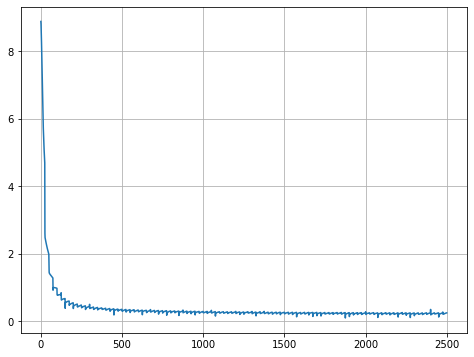

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(loss_info_to_plot)
plt.grid(True)
plt.show()

In [33]:
def evaluate(inp_sentence):
    start_token = [1]
    end_token = [2]
  
    sentence = preprocess_sentence(inp_sentence)
    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    
    encoder_input = tf.expand_dims(inputs, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
    decoder_input = [1]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_length_targ):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
        if predicted_id == targ_lang_tokenizer.word_index["<end>"]:
            return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
  
    sentence = inp_lang_tokenizer.encode(sentence)
  
    attention = tf.squeeze(attention[layer], axis=0)
  
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = ([targ_lang_tokenizer.index_word[i] for i in result.numpy()])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)
        
translate(u'Попробуй сделать это.')

Input: Попробуй сделать это.
Predicted translation: ['<start>', 'try', 'to', 'do', 'that', '.']


In [34]:
translate(u'Вы все еще дома?')

Input: Вы все еще дома?
Predicted translation: ['<start>', 'are', 'you', 'still', 'at', 'home', '?']


In [35]:
translate(u'Попробуй сделать это.')

Input: Попробуй сделать это.
Predicted translation: ['<start>', 'try', 'to', 'do', 'that', '.']


In [36]:
translate(u'Я люблю, когда идет снег.')

Input: Я люблю, когда идет снег.
Predicted translation: ['<start>', 'i', 'like', 'snow', 'when', '.']


In [37]:
translate(u'Я никогда такого не делаю.')

Input: Я никогда такого не делаю.
Predicted translation: ['<start>', 'i', 'never', 'do', 'that', '.']
